**MID EXAM Computer Vision**

**Nomor 3**

Nama  : Rio Pramana

NIM   : 2440016804

Kelas : LA01

Penjelasan akan diberikan pada markdown cell dan juga comment pada code

# Explanation of non-maximum suppression and hysteresis thresholding

## Non-maximum suppression

Before non-maximum suppression step is done, canny edge detector usually
produces an image with thick edges because it uses first-order derivatives.
However, what we want to achieve is an image with thin edges, that is why we need
to thin out the edges that are already found and performing non-maximum
suppression can achieve this.

To perform non-maximum suppression, we need to find the pixel with the
maximum value in the edge directions by going through all points on the gradient
intensity matrix. If there is a candidate edge pixel that has an edge strength less than
the edge strength of its two adjacent pixels in the gradient direction, then its edge
strength will be set to zero (suppressed).

The result that we expect from performing non-maximum suppression is a thinner
edge (Ideally, an edge with multiple pixels width will be thinned into an edge with
a single pixel width).

Contoh ilustrasi cara non-maximum suppression:
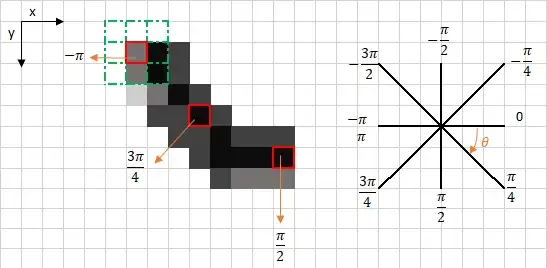

Jika kita melihat bagian edge atas kiri (yang ditandai dengan kotak hijau):

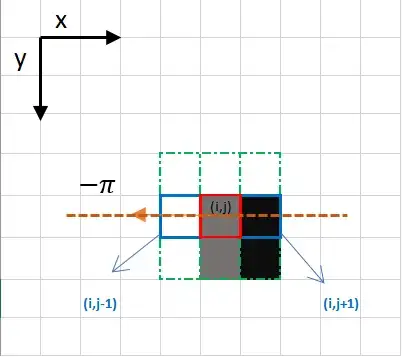

In the image above, the edge direction is represented by the orange line. So, if we are currently processing the (i,j) pixel, we will look at the pixels in the same direction: (i,j-1) & (i,j+1)

Then, from those 2 pixels (not the one currently being processed), we will check if any of those pixels have more intensity than the pixel being processed. We can see that (i,j-1) pixel have more intensity than the one currently being processed (the color is more white, closer to 255). That means we will keep the (i, j-1) pixel at it is, while the (i,j) pixel will be suppressed (usually the intensity will be set to 0)

Reference for the illustration: https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123

## Hysteresis thresholding

After performing non-maximum suppression, we are usually left with thin edges
that are broken (this event is also called streaking). To fix it (link the broken
lines/edges), we need to perform hysteresis thresholding (linking and thresholding).

First, we will perform the thresholding part first (double thresholding). We need to
define two thresholds (low and high) to help us identify 3 kinds of edges: irrelevant
edge, weak edge, and strong edge. For example, the high threshold is 0.8 (assume
all values are normalized to a scale of 0 to 1) and the low threshold is 0.2. Any pixel
that has a value higher than 0.8 is considered a strong edge, pixel that has a value
between 0.2 and 0.8 is considered a weak edge, and the rest are considered
irrelevant.

After double thresholding, we still need to determine which weak edge can be
considered as a strong/actual edge. This leads us to the next step which is called
hysteresis mechanism. The way it works is by looking at adjacent pixels of the weak
edge pixel that we are currently processing. If there are at least one strong edge as
the adjacent pixels, then we can mark that weak edge as a strong/actual edge.
Otherwise, we will mark it as irrelevant.

Contoh ilustrasi:
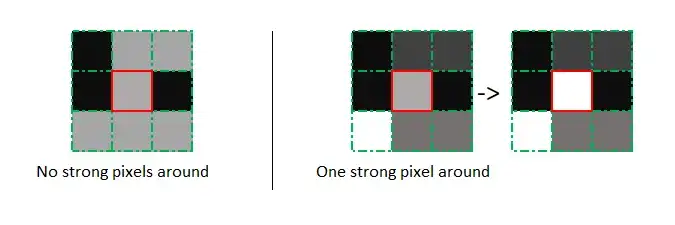

In the illustration above, there are 2 examples.

The one on the left illustrate when there are no strong edge pixel around the pixel currently being processed. Therefore, the current pixel (weak edge) is not transformed into a strong/actual edge pixel and will be marked as irrelevant.

The one on the right illustrate when there are at least 1 strong edge pixel around the pixel currently being processed. Therefore, the current pixel (weak edge) is transformed into a strong/actual edge pixel.

Reference for the illustration: https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123

# Implementation of Canny and LOG approach

## Canny

### Import libraries

In [1]:
#Import libraries
import numpy as np
import cv2
from matplotlib import pyplot as plt

### Noise reduction

Canny and LoG (Laplacian of Gaussian) depends heavily on derivatives that will make the edge detection highly sensitive to noises. Therefore, before we detect edges, we must apply noise reduction first, such as applying a gaussian blur filter to the image

In [2]:
#Define function to apply Gaussian blur filter to image
def GaussianBlur(image):
    #In this case, I will try to set the kernel size to 5x5
    filt_image = cv2.GaussianBlur(image, (5, 5), 0) #apply the filter with 5x5 kernel

    #For display purposes, I will display the original image and..
    #.. the filtered image here
    #Original image
    plt.subplot(121),plt.imshow(image, cmap = 'gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    #Filtered image
    plt.subplot(122),plt.imshow(filt_image, cmap = 'gray')
    plt.title('Gaussian Smoothed Image'), plt.xticks([]), plt.yticks([])
    plt.show()
    
    return filt_image #return the filtered image

### Gradient calculation

We can detect edges where there are changes in pixels' intensity

To detect these changes, we can apply Sobel filter that will highlight the intensity changes in horizontal and vertical directions. From the results of the Sobel filter, we can find edge gradient and direction for each pixel

In [3]:
#Define function to apply Sobel filter to the image
def SobelFilter(image):
    image = GaussianBlur(image) #Smooth the image first by calling GaussianBlur()
    size = image.shape
    # Convolved will be used to store the image after sobel filter is applied
    convolved = np.zeros(size)
    # G_x and G_y is to save the edge detection in both directions (x & y)
    G_x = np.zeros(size)
    G_y = np.zeros(size)
    #Initialize the kernel used for both directions (x & y)
    kernel_x = np.array(([-1, 0, 1], [-2, 0, 2], [-1, 0, 1]))
    kernel_y = np.array(([-1, -2, -1], [0, 0, 0], [1, 2, 1]))

    #Detect edges in x and y directions
    for i in range(1, size[0] - 1):
        for j in range(1, size[1] - 1):
            G_x[i, j] = np.sum(np.multiply(image[i - 1 : i + 2, j - 1 : j + 2], kernel_x))
            G_y[i, j] = np.sum(np.multiply(image[i - 1 : i + 2, j - 1 : j + 2], kernel_y))
    
    # We can get the final image by combining sobel filters from both directions
    convolved = np.sqrt(np.square(G_x) + np.square(G_y))
    convolved = np.multiply(convolved, 255.0 / convolved.max())
    convolved = convolved.astype('uint8')

    #For display purposes, I will display the Gaussian smoothed image and..
    #.. the sobel-filtered image here
    # Gaussian smoothed image
    plt.subplot(121),plt.imshow(image, cmap = 'gray')
    plt.title('Gaussian Smoothed Image'), plt.xticks([]), plt.yticks([])
    # Sobel filtered image
    plt.subplot(122),plt.imshow(convolved, cmap = 'gray')
    plt.title('Sobel Edge Detection'), plt.xticks([]), plt.yticks([])
    plt.show()

    # Get the angles for non-maximum suppression on the next step
    # We do it in this step because we are making use of G_x and G_y..
    # ..to get the angles
    angles = np.rad2deg(np.arctan2(G_y, G_x))
    angles[angles < 0] += 180
    
    return convolved, angles #return the sobel filtered image and angles

### Non-maximum suppression

Usually, the resulting image contains thick edges. However, ideally we want an image that contains thin edges (with single pixel width).

Therefore, the next thing to do is to thin out edges by performing non-maximum suppression

In [4]:
# Define function to perform non-maximum suppression
def non_maximum_suppression(image, angles):
    size = image.shape
    # Store the suppressed edges image, initialize all values as 0
    suppressed = np.zeros(size)
    # Go through all points on the gradient intensity matrix..
    # ..and find the pixel with maximum value in the edge directions
    for i in range(1, size[0] - 1):
        for j in range(1, size[1] - 1):
            if (0 <= angles[i, j] < 22.5) or (157.5 <= angles[i, j] <= 180):
                value_to_compare = max(image[i, j - 1], image[i, j + 1])
            elif (22.5 <= angles[i, j] < 67.5):
                value_to_compare = max(image[i - 1, j - 1], image[i + 1, j + 1])
            elif (67.5 <= angles[i, j] < 112.5):
                value_to_compare = max(image[i - 1, j], image[i + 1, j])
            else:
                value_to_compare = max(image[i + 1, j - 1], image[i - 1, j + 1])
            
            # If the pixel has a higher intensity than value_to_compare..
            # ..then we keep it, otherwise we will suppress it (the value stays as 0)
            if image[i, j] >= value_to_compare:
                suppressed[i, j] = image[i, j]
    # Return the suppressed image
    suppressed = np.multiply(suppressed, 255.0 / suppressed.max())
    
    # For display purposes, I will display the sobel filtered image and..
    #.. the suppressed image here
    # Sobel filtered image
    plt.subplot(121),plt.imshow(image, cmap = 'gray')
    plt.title('Sobel Edge Detection'), plt.xticks([]), plt.yticks([])
    # Suppressed image
    plt.subplot(122),plt.imshow(suppressed, cmap = 'gray')
    plt.title('Non-Maximum Suppression'), plt.xticks([]), plt.yticks([])
    plt.show()
   
    return suppressed

### Hysteresis thresholding

After performing non-maximum suppression, the results usually contains streaking (broken edges). Therefore, the next thing to do is performing hysteresis thresholding that will fix this issue

There are 2 parts of this method

The first one is double thresholding where we will set 2 thresholds (low and high) to identify 3 kinds of edges (strong edge, weak edge, irrelevant edge)

I found that the low threshold at 0 and the high threshold at 35 gives the best result for the image I am using

After double thresholding is done, we will perform edge tracking by hysteresis where we convert weak edges (pixels with intensity between low and high threshold) into strong edges if they have at least one adjacent pixel that is a strong edge

In [5]:
# Define a function to perform hysteresis thresholding
# We accept low and high threshold as a parameter of the function
def double_threshold_hysteresis(image, low, high):
    # Set weak and strong edge/pixel intensity
    weak = 50
    strong = 255
    size = image.shape
    # Save the result in another variable
    result = np.zeros(size)
    # Get weak and strong edges from image before hysteresis thresholding
    weak_x, weak_y = np.where((image > low) & (image <= high))
    strong_x, strong_y = np.where(image >= high)
    # Notice that we are ignoring irrelevant edges
    # Save it in variable result
    result[strong_x, strong_y] = strong
    result[weak_x, weak_y] = weak
    # Initialize dx & dy to help make the code for all directions..
    # ..easier, these are all possible directions (adjacent pixels)
    dx = np.array((-1, -1, 0, 1, 1, 1, 0, -1))
    dy = np.array((0, 1, 1, 1, 0, -1, -1, -1))
    
    # Instead of checking each weak edges/pixels, we will look through..
    # ..all strong edges/pixels
    # For every weak pixel/edge that is adjacent to the strong edge/pixel that..
    # ..we are currently checking, we will transform it into strong edge/pixel
    while len(strong_x):
        # Iterate through the list of strong edges/pixels
        x = strong_x[0]
        y = strong_y[0]
        strong_x = np.delete(strong_x, 0)
        strong_y = np.delete(strong_y, 0)
        # Check for every adjacent pixel of this strong edge/pixel
        for direction in range(len(dx)):
            new_x = x + dx[direction]
            new_y = y + dy[direction]
            # If we found an adjacent weak edge/pixel, make it strong
            if((new_x >= 0 & new_x < size[0] & new_y >= 0 & new_y < size[1]) and (result[new_x, new_y]  == weak)):
                # Transform weak edge/pixel into a strong one
                result[new_x, new_y] = strong
                np.append(strong_x, new_x)
                np.append(strong_y, new_y)
    # The rest of the edges (that are not strong) are set to 0 (marked as irrelevant)
    result[result != strong] = 0
    
    return result

To implement Canny edge detector, we just have to compile all the functions above into 1 full process/function:

In [6]:
def Canny(image, low, high):
    # Run Gaussian blur filter and sobel filter on the image
    image, angles = SobelFilter(image)
    # Perform non-maximum suppression
    image = non_maximum_suppression(image, angles)
    gradient = np.copy(image)
    # Perform hysteresis thresholding
    image = double_threshold_hysteresis(image, low, high)
    
    # Return the final image and gradient
    return image, gradient

### Running the canny edge detection

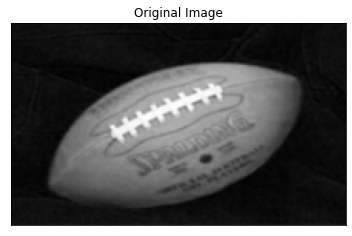

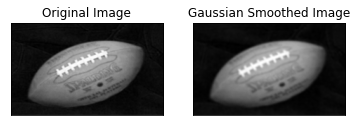

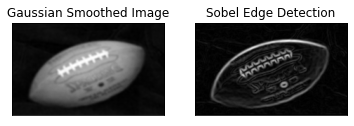

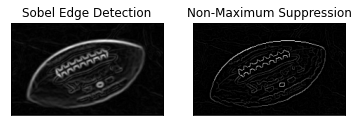

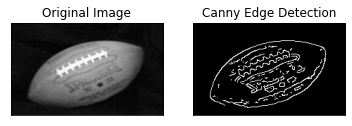

In [7]:
#Load image from files
img = cv2.imread('football.png', 0) #read the image and make it grayscale
plt.imshow(img, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.show() #show the image

# ==================== CANNY ======================
# For this example, I will set the threshold at 0 and 35
canny_img, gradient = Canny(img, 0, 35)

# Display the final image
# Original image
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
# Final image
plt.subplot(122),plt.imshow(canny_img, cmap = 'gray')
plt.title('Canny Edge Detection'), plt.xticks([]), plt.yticks([])

plt.show()

## LoG

While Canny edge detector is using first derivative of an image (Using Sobel), LoG is using the second derivative of an image

LoG uses only 1 kernel to calculate the second order derivatives in a single pass. However, because it is using second derivatives, it is more sensitive to noises than Canny

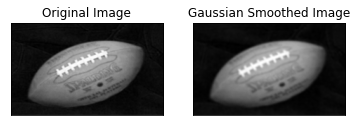

In [8]:
# We already have the original grayscale image, so the first step is to reduce noise by applying Gaussian blur
blur_img = GaussianBlur(img)

# The next step is to apply the LoG algorithm
laplacian_img = cv2.Laplacian(blur_img, cv2.CV_16S) #cv.CV_16S to make sure there are no overflow

Visualize LoG results:

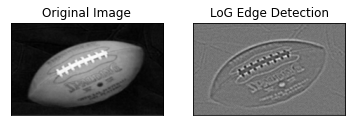

In [9]:
# Display the final image
# Original image
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
# Final image
plt.subplot(122),plt.imshow(laplacian_img, cmap = 'gray')
plt.title('LoG Edge Detection'), plt.xticks([]), plt.yticks([])

plt.show()

## Side by side comparison of Canny and LoG

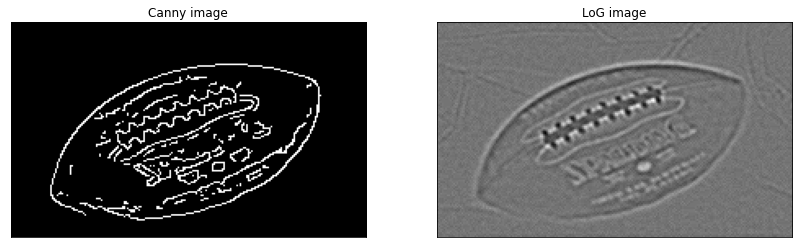

In [10]:
# Display the images
fig = plt.figure(figsize=(14,10))

# Original image
plt.subplot(121),plt.imshow(canny_img, cmap = 'gray')
plt.title('Canny image'), plt.xticks([]), plt.yticks([])

# Bandpass filtered image
plt.subplot(122),plt.imshow(laplacian_img, cmap = 'gray')
plt.title('LoG image'), plt.xticks([]), plt.yticks([])

plt.show()

The visualization result of LoG and Canny is quite different

We can clearly see the white lines in Canny as edges, but in LoG, it focuses on finding blobs/blob-like structures in the image using inflection points/zero crossings

Based on several research and articles I read online, it is believed that Canny tends to perform better than LoG as it is less sensitive to noise and LoG tend to detect false edges more than Canny. However, Canny’s better performance also comes with a cost, which is that Canny edge detector is much more complex (time-wise and space-wise) than LoG edge detector